In [1]:
# !pip3 install box2d-py

     |████████████████████████████████| 450kB 6.2MB/s 


In [27]:
import math
import gym
import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque

import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
Transition = namedtuple(
    "Transition",
    ("state", "action", "reward", "next_state", "done")
)

In [3]:
class Memories(object):
    def __init__(self, size):
        self.memory = deque(maxlen=size)
    
    def __add__(self, transition):
        self.memory.append(transition)
    
    def __len__(self):
        return len(self.memory)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [4]:
class FApprox(nn.Module):
    def __init__(self, in_shape, hidden, out_shape):
        super(FApprox, self).__init__()
        
        self.lin1 = nn.Linear(in_shape, hidden)
        self.lin2 = nn.Linear(hidden, hidden)
        self.lin3 = nn.Linear(hidden, out_shape)
    
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [5]:
class DQN(object):
    def __init__(self, model_params, dqn_params, seed):
        self.seed = seed
        self.env = gym.make("LunarLander-v2")
        self.set_seed(seed)
        # self.steps_done = 0
        # self.episode_count = 0

        self.hidden_size = model_params["hidden_size"]
        self.gamma = dqn_params["gamma"]
        self.batch_size = dqn_params["batch_size"]
        self.epsilon_max = dqn_params["epsilon_max"]
        self.epsilon_min  = dqn_params["epsilon_min"]
        self.epsilon_decay = dqn_params["epsilon_decay"]
        self.target_update = dqn_params["target_update"]
        
        self.state_shape = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n

        self.policy = FApprox(self.state_shape, self.hidden_size, self.n_actions)
        self.target = FApprox(self.state_shape, self.hidden_size, self.n_actions)
        self.target.load_state_dict(self.policy.state_dict())
        self.target.eval()

        self.optimizer = model_params["optim"](self.policy.parameters())
        self.loss_func = model_params["loss"]

        self.memory = Memories(size=10000)
        self.reward_threshold = 200
        self.n_episodes = 3000
        self.n_steps = 1000
        self.score_card = deque(maxlen=100)
        self.episode_rewards = []
        self.episode_epsilons = []
        self.last_episode = None
    

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        self.env.seed(seed)


    def select_action(self, state):
        sample = random.random()
        eps_threshold = max(self.epsilon_max, self.epsilon_min)
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy(state).max(1)[1].view(1, 1), eps_threshold
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], dtype=torch.long), eps_threshold


    def experience_replay(self):
        if len(self.memory) < self.batch_size: return
            
        train_data = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*train_data))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.tensor(batch.reward)

        done_batch = (torch.tensor(batch.done) == False).type(dtype=torch.long)

        predicted_Q_s_a = self.policy(state_batch).gather(1, action_batch)

        expected_Q_s_a = (done_batch * self.gamma * self.target(next_state_batch).max(1)[0]) + reward_batch
        expected_Q_s_a = expected_Q_s_a.float()

        loss = self.loss_func(predicted_Q_s_a, expected_Q_s_a.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def train_agent(self):
        with tqdm.trange(self.n_episodes) as t:
            for episode in t:
                episode_reward = 0
                state = self.env.reset()
                state = torch.tensor([state], dtype=torch.float32)
                for step in range(self.n_steps):
                    action, epsilon = self.select_action(state)
                    next_state, reward, done, _ = self.env.step(action.item())
                    next_state = torch.tensor([next_state], dtype=torch.float32)
                    
                    self.memory + Transition(state, action, reward, next_state, done)

                    state = next_state            
                    self.experience_replay()
                    episode_reward += reward
                    
                    if done: break
                
                self.score_card.append(episode_reward)
                running_reward = np.sum(self.score_card)/100
                
                t.set_description(f'Episode {episode+1}')
                t.set_postfix(
                    episode_reward=episode_reward, running_reward=running_reward,
                    epsilon=epsilon
                )

                self.episode_rewards.append(episode_reward)
                self.episode_epsilons.append(epsilon)

                if episode % self.target_update == 0:
                    self.target.load_state_dict(self.policy.state_dict())

                if running_reward >= self.reward_threshold:
                    break
                
                self.epsilon_max *= self.epsilon_decay
            
            self.last_episode = episode+1
    

    def save(self, path="./"):
        torch.save(self.policy, f"{path}/episode_rewards_{self.last_episode}.pt")
        f = open(f"{path}/episode_rewards_{self.last_episode}.txt", "w")
        f.write(
            f"SEED - {self.seed} \
            | BATCH_SIZE - {self.batch_size} \
            | GAMMA - {self.gamma} \
            | EPSILON_MAX - {self.epsilon_max} \
            | EPSILON_MIN - {self.epsilon_min} \
            | EPSILON_DECAY - {self.epsilon_decay} \
            | HIDDEN_SIZE - {self.hidden_size} \
            | TARGET_UPDATE - {self.target_update}\n"
        )
        for i in range(len(self.episode_rewards)):
            f.write(f"{self.episode_rewards[i]} | {self.episode_epsilons[i]}\n")
        f.close()

In [6]:
def main(
    seed = 42,
    gamma = 0.99,
    batch_size = 128,
    hidden_size = 128,
    epsilon_max = 1,
    epsilon_min = 0.005,
    epsilon_decay = 0.995,
    target_update = 5,
    loss = F.smooth_l1_loss,
    optimizer = optim.Adam
):
    model_params = {"hidden_size":hidden_size, "loss":loss, "optim":optimizer}
    dqn_params = {
        "gamma": gamma,
        "batch_size": batch_size,
        "epsilon_max": epsilon_max,
        "epsilon_min": epsilon_min,
        "epsilon_decay": epsilon_decay,
        "target_update": target_update
    }
    dqn_agent = DQN(model_params, dqn_params, seed)
    try:
        dqn_agent.train_agent()
    except:
        pass
    dqn_agent.save()


In [134]:
def test_agent(seed=42, path="./model.pt"):
    def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        
    env = gym.make("LunarLander-v2")
    set_seed(seed)
    
    policy = torch.load(path)
    policy.eval()

    score_card = []
    for episode in range(100):
        done = False
        episode_reward = 0
        state = env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        while not done:
            action = policy(state).max(1)[1].view(1, 1)
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor([next_state], dtype=torch.float32)
            state = next_state            
            episode_reward += reward
            if done: break

        score_card.append(episode_reward)

    return score_card


def training_stat(path="models/base.txt"):
    training_score = []
    epsilons = []
    running_average = []
    f = open(path)
    last_episode = None
    for line in f:
        if line.startswith("SEED"):
            last = line.split("| ")[-1]
            if last.startswith("LAST EPISODE"):
                last_episode = last.split(" - ")[-1]
                if last_episode.strip().isdigit():
                    last_episode = int(last_episode)
        else:
            training_score.append(float(line.split(" | ")[0]))
            epsilons.append(float(line.split(" | ")[1]))
            running_average.append(np.sum(training_score[-100:])/100)
            
    f.close()
    return last_episode, training_score, epsilons, running_average


def test_param(path="models/base"):
    test_scores = []
    txt_path = f"{path}.txt"
    model_path = f"{path}.pt"
    ep, train_scores, _, _ = training_stat(txt_path)
    for i in tqdm.notebook.tqdm(range(10)):
        test_scores.append(np.mean(test_agent(42+i, model_path)))
#     print(test_scores)
    return np.mean(test_scores), np.std(test_scores), np.mean(train_scores), ep


def test_all_params(path="project_2"):
    param_stat = {}
    for p in glob.glob(f"{path}/gamma*.pt"):
        xpath = p.rstrip(".pt")
        print(xpath)
        stat = test_param(xpath)
        param_stat[xpath] = stat
    return param_stat

In [ ]:
param_stat = test_all_params()

In [ ]:
base_test_scores = test_agent(path="project_2/base.pt")
base_train_ep, base_train_scores, base_epsilons, base_avgs = training_stat(path="project_2/base.txt")

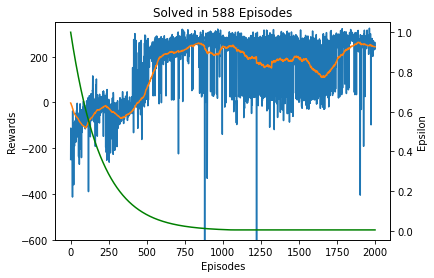

In [59]:
fig, ax=plt.subplots()
ax2 = ax.twinx()
ax.plot(base_train_scores, label="training_scores")
ax.plot(base_avgs, label="training_scores")
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.set_ylim([-600, 350])
ax2.plot(base_epsilons, color="green", label="epsilons")
ax2.set_ylabel("Epsilon")
plt.title(f"Solved in {base_train_ep} Episodes")
plt.show()

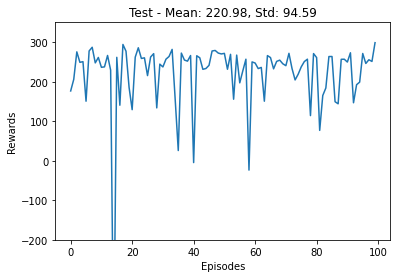

In [64]:
fig, ax=plt.subplots()
ax.plot(base_test_scores)
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.set_ylim([-200, 350])
plt.title(f"Test - Mean: {round(np.mean(base_test_scores), 2)}, Std: {round(np.std(base_test_scores), 2)}")
plt.show()

In [132]:
def get_label(p):
    if "1" in p: return "gamma=1"
    if ".95" in p: return "gamma=.95"
    if ".9" in p: return "gamma=.9"
    if ".85" in p: return "gamma=.85"
    if ".8" in p: return "gamma=.8"

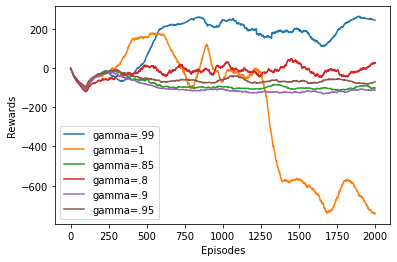

In [133]:
fig, ax = plt.subplots()
# ax2 = ax.twinx()
ax.plot(base_avgs, label="gamma=.99")
for p in glob.glob("project_2/gamma*.txt"):
    train_ep, train_scores, epsilons, avgs = training_stat(path=p)
#     ax.plot(train_scores, label="training_scores")
    ax.plot(avgs, label=get_label(p))
#     ax2.plot(epsilons, label="epsilons")

ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
# ax.set_ylim([-600, 350])    
# ax2.set_ylabel("Epsilon")
# plt.title(f"Solved in {base_train_ep} Episodes")
plt.legend()
plt.show()

In [77]:
df = pd.DataFrame(param_stat).T
df.index = list(map(lambda x: x.strip("project_2/"),df.index))
df.columns = ["test_mean", "test_std", "train_mean", "solved_episode"]
df["solved_episode"] = df["solved_episode"].apply(lambda x: 10000 if type(x) == str else x)

In [78]:
df.sort_values(by="test_mean", ascending=False)

,test_mean,test_std,train_mean,solved_episode
decay-90.0,241.983438,7.256775,124.251291,442.0
bas,231.724561,6.782584,146.426468,588.0
hidden-128,224.32764,7.633797,150.544292,1235.0
decay-95.0,179.56242,6.542588,146.483088,554.0
hidden-64,101.233742,13.789747,163.516554,444.0
decay-85.0,75.118252,15.695858,146.696246,472.0
decay-80,67.989377,10.212869,130.73973,582.0
decay-99.0,37.863617,4.134355,103.758589,708.0
hidden-16,-166.516943,7.368875,20.001197,10000.0
hidden-256,-698.810303,20.807877,-55.012733,696.0


In [42]:
df.sort_values(by=["solved_episode", "test_mean"], ascending=True)

,test_mean,test_std,train_mean,solved_episode
project_2/e_decay-90.0,241.983438,7.256775,124.251291,442.0
project_2/hidden-64,101.233742,13.789747,163.516554,444.0
project_2/e_decay-85.0,75.118252,15.695858,146.696246,472.0
project_2/e_decay-95.0,179.56242,6.542588,146.483088,554.0
project_2/e_decay-80,67.989377,10.212869,130.73973,582.0
project_2/base,231.724561,6.782584,146.426468,588.0
project_2/hidden-256,-698.810303,20.807877,-55.012733,696.0
project_2/e_decay-99.0,37.863617,4.134355,103.758589,708.0
project_2/hidden-128,224.32764,7.633797,150.544292,1235.0
project_2/hidden-16,-166.516943,7.368875,20.001197,10000.0


In [96]:
e_decay = df[df.index.isin(["bas", "decay-90.0", "decay-95.0", "decay-99.0", "decay-85.0", "decay-80"])].test_mean

In [103]:
e_decay_solved = df[df.index.isin(["bas", "decay-90.0", "decay-95.0", "decay-99.0", "decay-85.0", "decay-80"])].solved_episode

In [98]:
e_decay.index = ['.995', '.80', '.85', '.90', '.99', '.95']

In [104]:
e_decay_solved.index = ['.995', '.80', '.85', '.90', '.99', '.95']

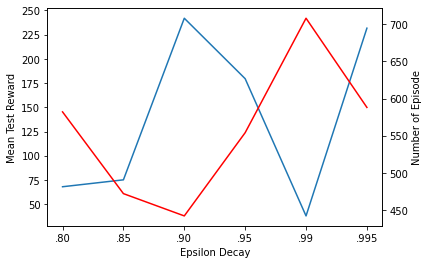

In [107]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(e_decay.sort_index())
ax2.plot(e_decay_solved.sort_index(), color="red")
ax.set_xlabel("Epsilon Decay")
ax.set_ylabel("Mean Test Reward")
ax2.set_ylabel("Number of Episode")
plt.show()

In [108]:
df

,test_mean,test_std,train_mean,solved_episode
bas,231.724561,6.782584,146.426468,588.0
decay-80,67.989377,10.212869,130.73973,582.0
decay-85.0,75.118252,15.695858,146.696246,472.0
hidden-256,-698.810303,20.807877,-55.012733,696.0
hidden-128,224.32764,7.633797,150.544292,1235.0
decay-90.0,241.983438,7.256775,124.251291,442.0
decay-99.0,37.863617,4.134355,103.758589,708.0
hidden-16,-166.516943,7.368875,20.001197,10000.0
decay-95.0,179.56242,6.542588,146.483088,554.0
hidden-64,101.233742,13.789747,163.516554,444.0


In [122]:
dd = df.loc[["hidden-16", "bas", "hidden-64", "hidden-128"]]
dd.index = [16, 32, 64, 128]

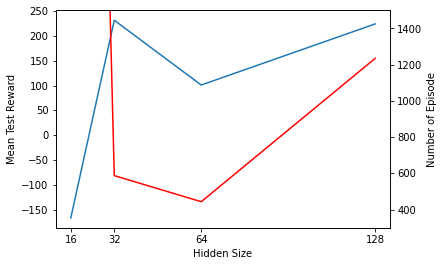

In [124]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(dd.test_mean, label="Test Mean")
ax2.plot(dd.solved_episode, color="red")
ax2.set_ylim([300, 1500])
ax.set_xlabel("Hidden Size")
ax.set_ylabel("Mean Test Reward")
ax2.set_ylabel("Number of Episode")
plt.xticks([16, 32, 64, 128])
# plt.legend()
plt.show()

In [43]:
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display
import tensorflow_docs.vis.embed as embed

In [44]:
display = Display(visible=0, size=(400, 300))
display.start()

def render_episode(model): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    done = False
    q_vals = []
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    while not done:
        prediction = model(state)
        q_val = prediction.max(1)[0].item()
        action = prediction.max(1)[1].view(1, 1)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor([next_state], dtype=torch.float32)
        state = next_state            
        
        q_vals.append(q_val)
        # Render screen every 10 steps
#         if i % 10 == 0:
        screen = env.render(mode='rgb_array')
        images.append(Image.fromarray(screen))
        if done: break

    return images, q_vals

env = gym.make("LunarLander-v2")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)
        
set_seed(42)
    
model = torch.load("project_2/model.pt")
model.eval()

# Save GIF image
images, q_vals = render_episode(model)
image_file = 'LunarLander-v2.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


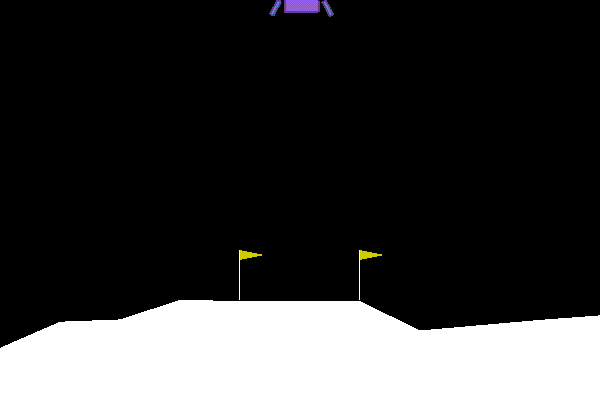

In [45]:
embed.embed_file(image_file)

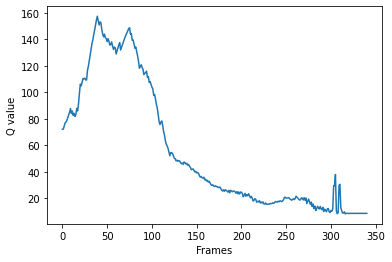

In [47]:
plt.plot(q_vals)
plt.xlabel("Frames")
plt.ylabel("Q value")
plt.show()